<a href="https://colab.research.google.com/github/singjc/diffusion-deconvolution-dia-msms/blob/main/nbs/test_data_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install git+https://github.com/OpenMS/pyopenms_viz.git
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from bokeh.io import output_notebook
output_notebook();
import matplotlib.pyplot as plt


# set global plotting backend for pandas
pd.options.plotting.backend = "ms_matplotlib" # one of: "ms_bokeh" "ms_matplotlib" "ms_plotly"


  Cloning https://github.com/OpenMS/pyopenms_viz.git to /tmp/pip-req-build-a2_yrw4u
  Running command git clone --filter=blob:none --quiet https://github.com/OpenMS/pyopenms_viz.git /tmp/pip-req-build-a2_yrw4u
  Resolved https://github.com/OpenMS/pyopenms_viz.git to commit 431015932f3ddd73554c59d70acb10e9e2c4a7cc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir("drive/MyDrive/2024-07-diffusionDeconvolution/code/dquartic")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['__pycache__', 'utils', '__init__.py']

In [3]:
import sys
sys.path.append('drive/MyDrive/2024-07-diffusionDeconvolution/code/')

# Now we can import the library and use the function.
# import importlib
# importlib.reload(dquartic)

from dquartic.utils.data_loader import DIAMSDataset
# help(DIAMSDataset)

In [4]:
# Create the dataset
dataset = DIAMSDataset('drive/MyDrive/2024-07-diffusionDeconvolution/ms2_data_cat_int32.npy', 'drive/MyDrive/2024-07-diffusionDeconvolution/ms1_data_int32.npy', split=True)

# Create the DataLoader
batch_size = 32  # Adjust this based on your model and memory constraints
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

for batch_ms2_s1, batch_ms1_s1, batch_ms2_s2, batch_ms1_s2 in dataloader:
    print(f"MS2 split 1 batch shape: {batch_ms2_s1.shape}")
    print(f"MS1 split 1 batch shape: {batch_ms1_s1.shape}")
    print(f"MS2 split 2 batch shape: {batch_ms2_s2.shape}")
    print(f"MS1 split 2 batch shape: {batch_ms1_s2.shape}")

    # Function to convert MS2 batch to DataFrame
    def ms2_to_df(batch_ms2):
        ms2_df = pd.DataFrame()
        for i in range(batch_ms2.shape[0]):
            sample = batch_ms2[i]
            df = pd.DataFrame(sample.numpy())
            df['sample_id'] = i
            df = df.melt(id_vars=['sample_id'], var_name='x', value_name='intensity')
            df['y'] = df.index % 34
            ms2_df = pd.concat([ms2_df, df], ignore_index=True)
        return ms2_df

    # Function to convert MS1 batch to DataFrame
    def ms1_to_df(batch_ms1):
        ms1_df = pd.DataFrame()
        for i in range(batch_ms1.shape[0]):
            sample = batch_ms1[i]
            df = pd.DataFrame(sample.numpy().reshape(1, -1))
            df['sample_id'] = i
            df = df.melt(id_vars=['sample_id'], var_name='y', value_name='intensity')
            ms1_df = pd.concat([ms1_df, df], ignore_index=True)
        return ms1_df

    # Convert all batches to DataFrames
    ms2_df_s1 = ms2_to_df(batch_ms2_s1)
    ms1_df_s1 = ms1_to_df(batch_ms1_s1)
    ms2_df_s2 = ms2_to_df(batch_ms2_s2)
    ms1_df_s2 = ms1_to_df(batch_ms1_s2)

    print("\nMS2 Split 1 DataFrame:")
    print(ms2_df_s1.head())
    print("\nMS1 Split 1 DataFrame:")
    print(ms1_df_s1.head())
    print("\nMS2 Split 2 DataFrame:")
    print(ms2_df_s2.head())
    print("\nMS1 Split 2 DataFrame:")
    print(ms1_df_s2.head())

    break  # Remove this if you want to process all batches


MS2 split 1 batch shape: torch.Size([32, 34, 40000])
MS1 split 1 batch shape: torch.Size([32, 34])
MS2 split 2 batch shape: torch.Size([32, 34, 40000])
MS1 split 2 batch shape: torch.Size([32, 34])

MS2 Split 1 DataFrame:
   sample_id  x  intensity  y
0          0  0        0.0  0
1          0  0        0.0  1
2          0  0        0.0  2
3          0  0        0.0  3
4          0  0        0.0  4

MS1 Split 1 DataFrame:
   sample_id  y  intensity
0          0  0    86607.0
1          0  1    84523.0
2          0  2    77845.0
3          0  3    80041.0
4          0  4    82298.0

MS2 Split 2 DataFrame:
   sample_id  x  intensity  y
0          0  0        0.0  0
1          0  0        0.0  1
2          0  0        0.0  2
3          0  0        0.0  3
4          0  0        0.0  4

MS1 Split 2 DataFrame:
   sample_id  y  intensity
0          0  0   155050.0
1          0  1   156362.0
2          0  2   166535.0
3          0  3   174485.0
4          0  4   190442.0


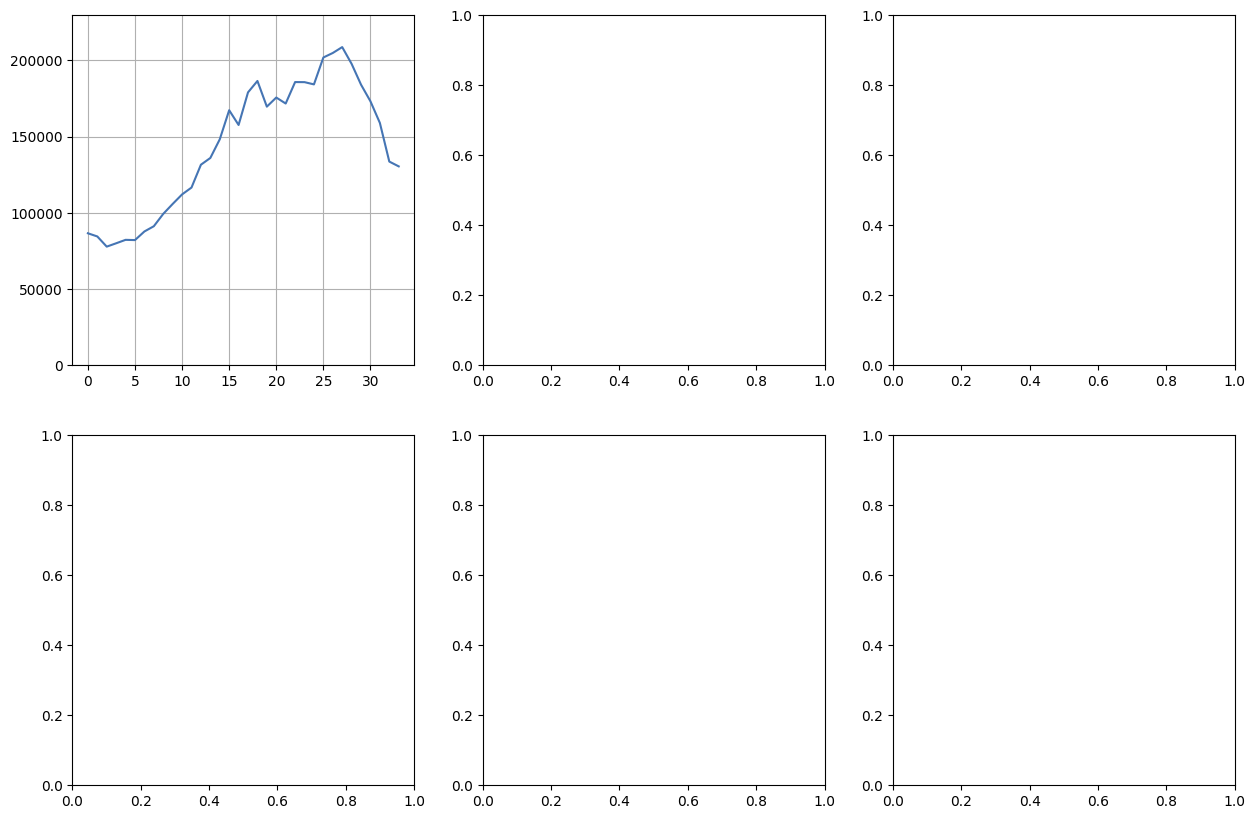

/usr/local/lib/python3.10/dist-packages/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)
/usr/local/lib/python3.10/dist-packages/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)


In [15]:
# Create a figure with 6 subplots arranged in 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

ms1_df_s1.loc[ms1_df_s1.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", grid=False, fig=axs[0,0])
ms2_df_s1.loc[ms2_df_s1.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", by="x", grid=False, legend={'show':False}, fig=axs[0,1])
ms1_df_s2.loc[ms1_df_s2.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", grid=False, fig=axs[1,0])
ms2_df_s2.loc[ms2_df_s2.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", by="x", grid=False, legend={'show':False}, fig=axs[1,1])

In [16]:
plt.tight_layout()  # Adjust the layout

<Figure size 640x480 with 0 Axes>

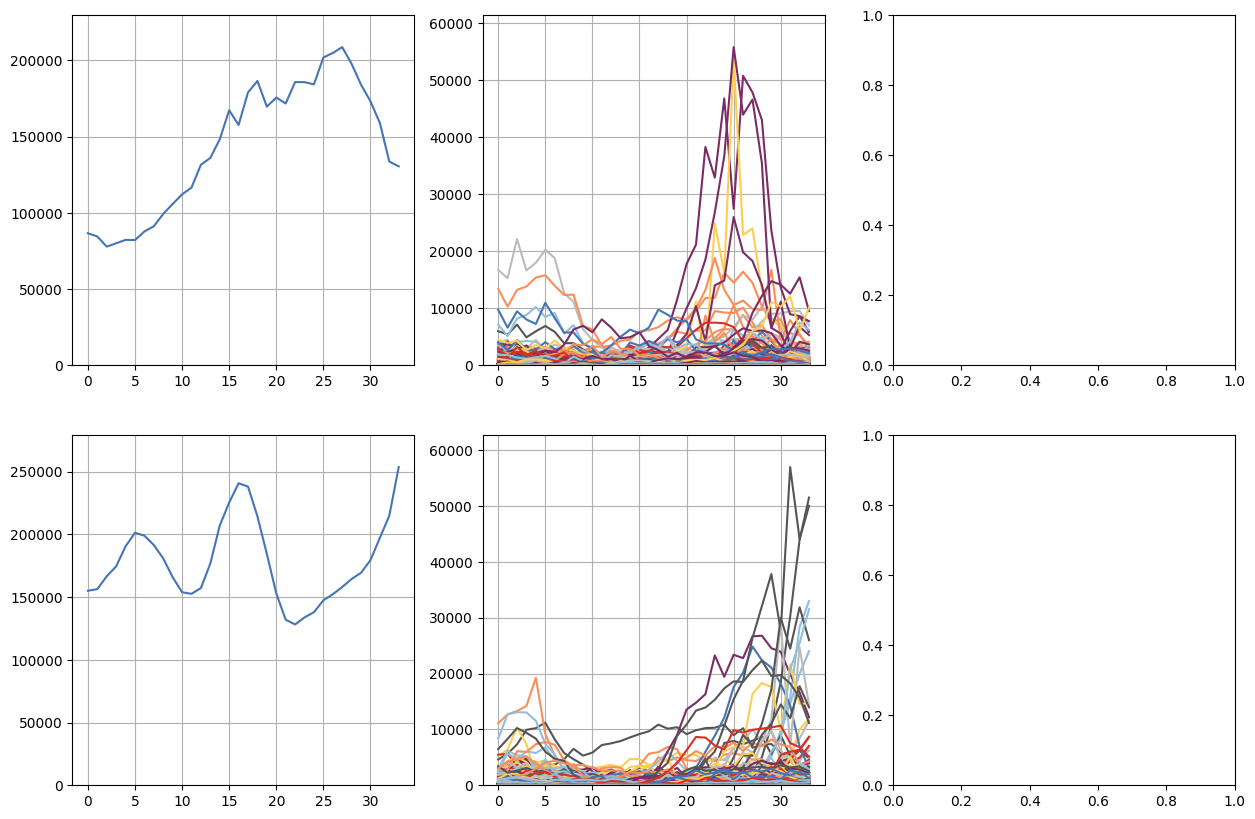

In [17]:
fig

In [18]:
batch_ms2_mixed = (batch_ms2_s1*0.5) + (batch_ms2_s2*0.75)

In [19]:
ms2_mixed_df = ms2_to_df(batch_ms2_mixed)

In [20]:
ms2_mixed_df.loc[ms2_mixed_df.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", by="x", grid=False, legend={'show':False}, fig=axs[0,2])
ms2_mixed_df.loc[ms2_mixed_df.sample_id==0].plot(kind="chromatogram", x="y", y="intensity", by="x", grid=False, legend={'show':False}, fig=axs[1,2])

/usr/local/lib/python3.10/dist-packages/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)
/usr/local/lib/python3.10/dist-packages/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)


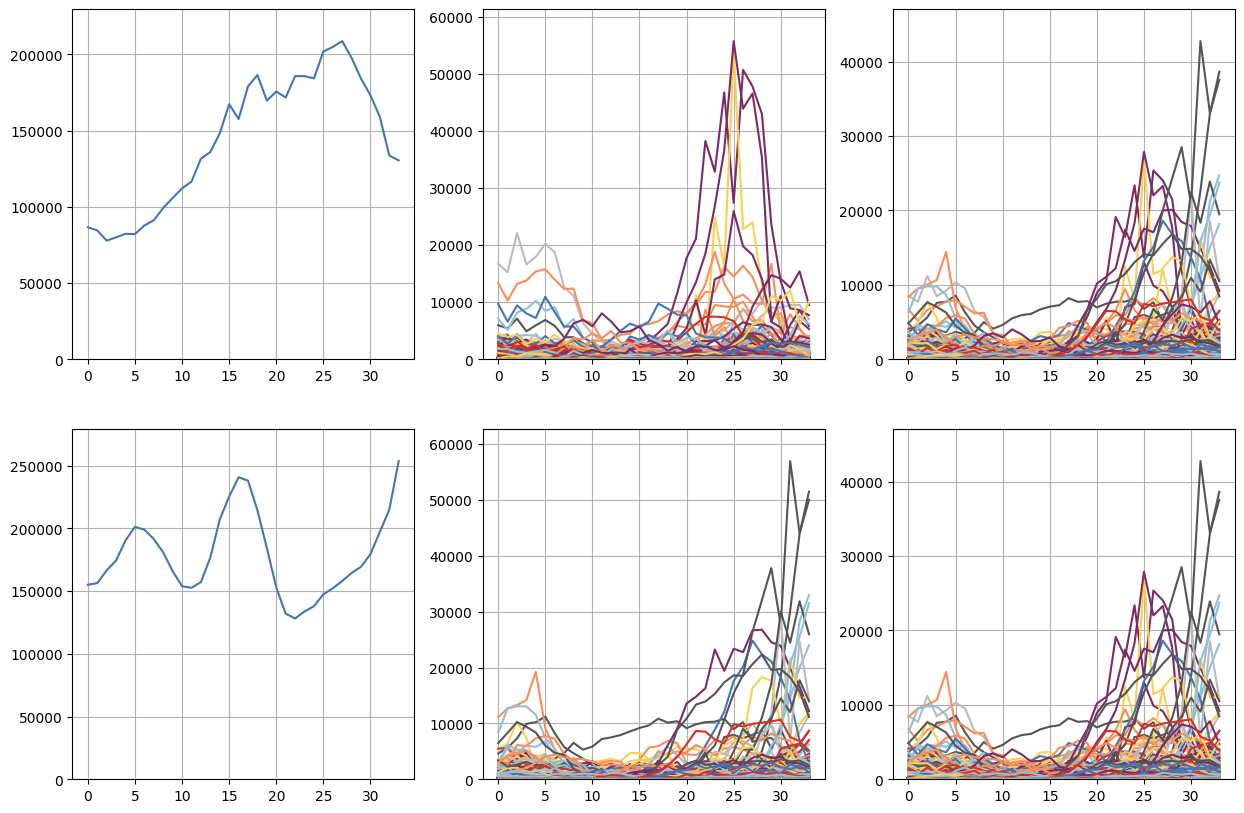

In [21]:
fig